# TD Learning


If the MDP is known, then we can use Value Iteration to calculate the actual values of V and use them to infer the optimal policy. If we don't know the MDP, we can use MC or TD learning. For this exercise you will implement the TD learning algorithm in the same MDP as before

## The MDP

The problem is provided by the <b>gym</b>-environment. 

The task is to reach the goal state <b>G</b>, starting from initial state <b>S</b>, without falling into Hole <b>H</b> and die miserably. That, means we have to reach the goal traversing the <b>F</b>  tiles. Remember that in the Frozenworld Problem the ground is slippery, meaning if you move right, you can also move upward or downward as well (the transition model is non-deterministic).

The map of the MDP is the following:

        S F F F
        F H F H
        F F F H
        H F F G

## TD Learning

In TD learning we do not have access to the underlying MDP, thus we cannot estimate the <b>optimal</b> value function V. What we can do instead is estimate the value function of the policy $\pi$ applied to the MDP using the TD(0) method:

$V^{\pi} \left( s \right) = V^{\pi} \left( s \right) + \alpha \left[ r + \gamma V^{\pi} \left( s' \right) - V^{\pi} \left( s \right) \right]$

Note here, that unlike Monte Carlo prediction, this update is performed after each transition in the episode, meaning we are in state $s$, perform action $a$, receive reward $r$ and end up in a new state $s'$.

<b>ATTENTION</b>: As before, an importan aspect to consider is that special care needs to be taken when we are at a terminal state (e.g., in the Goal <b>G</b> or Hole <b>H</b> states of the Frozen Lake MDP). Here, no matter what action we execute, we cannot "escape" this state, so the Value Iteration implementation should be adapted accordingly.

## The TD(0) Agent

In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

from FrozenLake import FrozenLakeEnv

class TD_Agent:
    def __init__(self, discount_factor, learning_rate):
        self.g      = discount_factor
        self.lr     = learning_rate
        
        self.MDP = FrozenLakeEnv()
        self.MDP.seed(0)
        self.terminals = [5,7,11,12,15]

        
        # MDP.p_a: uniform action probability (25% chance an action is selected)
        # MDP.p_s_: uniform next-state probability
        # MDP.P_ss_(s,a): set of all possible states when taking action a in state s
        # MDP.R(s): reward in state s
        # MDP.A: set of all possible actions,e.g. full action space
        # MDP.S_(s,a): next state when taking action a in state s 
        
        # 4x4 gridworld:
        #"S F F F",
        #"F H F H",
        #"F F F H",
        #"H F F G"

        #S: Start (constant starting position, reward=0)
        #F: Ice  (introduces stochastic action, reward=0)
        #H: Hole (ends episode, reward=0)
        #G: Goal (ends episode, reward=1)
        
        # states = {0,1,...,15}
        self.V = np.zeros(shape=(16), dtype=float)   
        
    def action(self,s):
        #LEFT = 0
        #DOWN = 1
        #RIGHT = 2
        #UP = 3
            
        # use uniform and random policy
        action = np.random.uniform()

        if action <= 0.25: return 0
        if action <= 0.50: return 1
        if action <= 0.75: return 2
        if action <= 1.00: return 3
    
    # TD Learning    
    def update_TD(self,s,a,r,s_):
        self.V[s]  = self.V[s] + self.lr*(r+self.g*self.V[s_]-self.V[s])  

## Base Loop

In [2]:
agentTD = TD_Agent(discount_factor=0.95,learning_rate=0.005)
env = gym.make('FrozenLake-v0')

In [3]:
for i in range(100000):
    s = env.reset()  # Initializes the Frozen Lake MDP
    while True:
        a = agentTD.action(s)  # Apply the random policy
        s_,r,done,_ = env.step(a)  # Observe the next state and the reward
        
        agentTD.update_TD(s,a,r,s_)  # Update the value function estimate using the latest transition
                           
        s = s_
        
        if done:  # If episode terminated (i.e., the agent fell into a hole, discovered the goal state or max. number of steps were done)
            break 

## Visualization

### Value Function

[[0.00766771 0.00741708 0.01459295 0.00653726]
 [0.00957835 0.         0.03139907 0.        ]
 [0.02289711 0.06945704 0.12939718 0.        ]
 [0.         0.13918085 0.4354858  0.        ]]


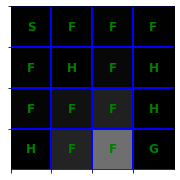

In [4]:
V = agentTD.V.copy()
plt.figure(figsize=(3,3))
plt.imshow(V.reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))
ax = plt.gca()
ax.set_xticks(np.arange(4)-.5)
ax.set_yticks(np.arange(4)-.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
Y, X = np.mgrid[0:4, 0:4]
a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
for y in range(4):
    for x in range(4):
        u, v = a2uv[a]
        plt.text(x, y, str(agentTD.MDP.unwrapped.desc[y,x].item().decode()),
                 color='g', size=12,  verticalalignment='center',
                 horizontalalignment='center', fontweight='bold')
plt.grid(color='b', lw=2, ls='-')

print(V.reshape(4,4))

### Policy

Can you find a better policy based on the estimated Value function? 

Remember that you do not know the transition model of the MDP (i.e., if you are in state $s$ = 1 and take action $a$ = right, you don't know the possible next states $s'$)